# 广告点击率预测

广告点击率(CTR)预测是广告行业的典型应用，是评估广告效果的一个非常重要的指标。通过历史数据训练预测模型，对于每天的增量数据进行预测，找出广告的CTR符合标准的样本进行投放。
## 数据集介绍
数据集来自于kaggle，数据包含了10天的Avazu的广告点击数据，训练集10000个，测试集1000个。每一条广告包含：广告id、时间、广告位置等属性。

![](https://ai-studio-static-online.cdn.bcebos.com/1682d3186a5d4fedab10c4ad3a7f3656e3db56852e5c4fdbb4fb26005c0ba811)

## 任务1：导入库和数据集与数据预处理
- 读入训练数据和测试数据，划分data和label
- 将string类型的特征转化为int型：1）进行 one-hot 编码处理，会得到高维稀疏的特征，增大内存开销；2）使用python内置的hash函数将那些类型为object的特征变量映射为一定范围内的整数(原来的string被映射成了integer)，可以大大降低内存的消耗。



In [10]:
import gzip
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

types_train = {
    'id': np.dtype(int),
    'click': np.dtype(int),         #是否点击,1表示被点击,0表示没被点击
    'hour': np.dtype(int),          #广告被展现的日期+时间
    'C1': np.dtype(int),            #匿名分类变量
    'banner_pos': np.dtype(int),    #广告位置
    'site_id': np.dtype(str),       #站点Id
    'site_domain': np.dtype(str),   #站点域名
    'site_category': np.dtype(str), #站点分类
    'app_id': np.dtype(str),        # appId
    'app_domain': np.dtype(str),    # app域名
    'app_category': np.dtype(str),  # app分类
    'device_id': np.dtype(str),     #设备Id
    'device_ip': np.dtype(str),     #设备Ip
    'device_model': np.dtype(str),  #设备型号
    'device_type': np.dtype(int),   #设备型号
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),   #匿名分类变量
    'C15': np.dtype(int),   #匿名分类变量
    'C16': np.dtype(int),   #匿名分类变量
    'C17': np.dtype(int),   #匿名分类变量
    'C18': np.dtype(int),   #匿名分类变量
    'C19': np.dtype(int),   #匿名分类变量
    'C20': np.dtype(int),   #匿名分类变量
    'C21':np.dtype(int)     #匿名分类变量
}

# 添加列名
header_row = ['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', \
              'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model',\
              'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19',\
              'C20', 'C21']

# 读入训练数据和测试数据
train = pd.read_csv('train_data.csv', names=header_row, dtype=types_train)
test = pd.read_csv('test_data.csv', names=header_row, dtype=types_train)
# 去除第0行（表示列的编号，不是样本）
train = train.drop(labels=train.index.values[0])
test = test.drop(labels=test.index.values[0])
print(test.shape)
#print(train)

# 划分data和label
train_data = train.drop('click',1) #去除click 这一列,use drop()
print(train_data.shape)
train_label = train.loc[:,'click'] #提取click 这一列,use loc[]，注意中括号

test_data = test.drop('click',1) #去除click 这一列
print(test_data.shape)
test_label = test.loc[:,'click'] #提取click 这一列


# 数据预处理
# 使用pd.get_dummies对非数值型特征进行 one-hot 编码处理，得到高维稀疏的特征
train_data1 = pd.get_dummies(train_data) 
print(train_data1.shape)
#print(train_data1)

# 编写convert_obj_to_int()函数将string类型的特征转换为int型
def convert_obj_to_int(self):
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0, len(object_list_columns)):
        if object_list_dtypes[index] == object:
            # 使用hash函数将那些类型为object的特征变量映射为一定范围内的整数(原来的string被映射成了integer)
            self[object_list_columns[index] + new_col_suffix] = self[object_list_columns[index]].map(lambda x: hash(x))
            self.drop([object_list_columns[index]], inplace=True, axis=1)
    return self

# 调用convert_obj_to_int()函数，将string类型转换为int型    
train_data = convert_obj_to_int(train_data)
print(train_data.shape)
#print(train_data.info())
test_data = convert_obj_to_int(test_data) 
print(test_data.shape)

(1000, 24)
(10000, 23)
(1000, 23)
(10000, 10531)
(10000, 23)
(1000, 23)


## 任务2：特征分析
以广告在网页中的位置(banner_pos)为例，查看banner_pos和最终类标(click)之间的关系。
- 查看banner_pos在数据集中的取值分布；
- 查看不同banner_pos对点击率click的贡献。

In [11]:
from pandas import DataFrame 

# 查看banner_pos在数据集中的取值分布
print(train.banner_pos.value_counts()/len(train))

# 查看不同banner_pos对点击率click的贡献
banner_pos_val = train.banner_pos.unique()
banner_pos_val.sort()
ctr_avg_list = []
for i in banner_pos_val:
    selected_data = train.loc[train.banner_pos == i]
    ctr_avg = selected_data.click.mean()
    ctr_avg_list.append(ctr_avg)
    print(" banner 位置: {},  点击率: {}".format(i, ctr_avg))

0    0.8041
1    0.1951
2    0.0007
4    0.0001
Name: banner_pos, dtype: float64
 banner 位置: 0,  点击率: 0.16975500559631887
 banner 位置: 1,  点击率: 0.19067145053818554
 banner 位置: 2,  点击率: 0.14285714285714285
 banner 位置: 4,  点击率: 0.0


## 任务3：模型训练与评估
- 调用sklearn的逻辑回归函数LogisticRegression()，进行模型训练
- 对测试集test_data进行预测，计算预测结果的各项指标acc, pre, recall, auc
- 绘制ROC曲线（使用预测的概率值而不是预测类标）
- 选做：**自定义逻辑回归函数MyLogisticRegression()**，进行模型训练与预测，与上述结果比较。

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Finish Training!
0.812
0.812
0.812
0.5


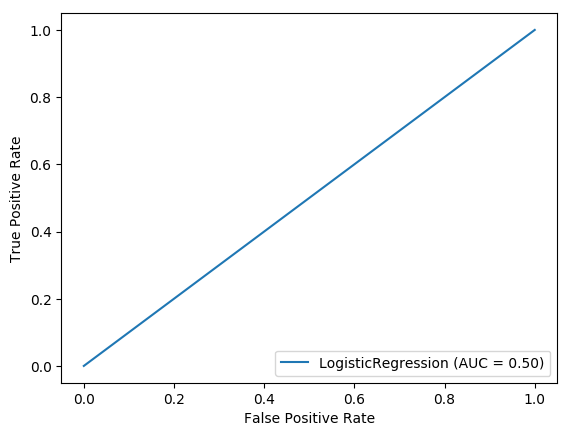

In [12]:
# 调用sklearn的逻辑回归函数LogisticRegression()
from sklearn.linear_model import LogisticRegression #from sklearn 会报错import error
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,auc,roc_curve,roc_auc_score,plot_roc_curve
clf = LogisticRegression()
# 模型训练
clf.fit(train_data,train_label)  
print("Finish Training!")
# 模型预测 
pred = clf.predict(test_data.fillna(0))
#print(pred)
#print(test_label) 
# 计算模型的acc, pre, recall, auc，并输出
# 请(在下方作
#print(confusion_matrix(test_label,pred))
acc = accuracy_score(test_label,pred)
print(acc)
pre = precision_score(test_label,pred,average='micro') #要加上average='micro'
print(pre) #    
recall = recall_score(test_label,pred,average='micro')
print(recall)
auc = roc_auc_score(test_label,pred)
print(auc)
# 绘制roc曲线
# 请在下方作答
plot_roc_curve(clf,test_data,test_label) #display 容器有何作用
#plt.show